In [1]:
import findspark
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
findspark.init()
import pyspark
spark = SparkSession.builder.appName("Project").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark
# cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
# print("You are working with", cores, "core(s)")
# spark

You are working with 1 core(s)


In [2]:
cardio = spark.read.csv('Datasets/CardioGoodFitness.csv',inferSchema=True,header=True)

In [3]:
cardio.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Usage: integer (nullable = true)
 |-- Fitness: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Miles: integer (nullable = true)



In [4]:
cardio.limit(5).toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


In [5]:
# Counting null values in each column
cardio.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cardio.columns]).toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,0,0,0,0,0,0,0,0,0


In [6]:
# Count duplicates in all columns
duplicates = cardio.groupBy(cardio.columns).count().filter("count > 1")

# Show the duplicates
duplicates.toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles,count


In [7]:
# format the columns with two decimal places
cardio_desc = cardio.describe()
for col_name in ['Age', 'Education', 'Usage', 'Fitness', 'Income', 'Miles']:
    cardio_desc = cardio_desc.withColumn(col_name, format_number(col(col_name).cast("double"), 2))

# hide decimals if all zeroes
cardio_desc = cardio_desc.select(
    *[when(col(c).rlike('\.00$'), regexp_replace(col(c), '\.00', '')).otherwise(col(c)).alias(c) 
      for c in cardio_desc.columns]
)

cardio_desc.toPandas()

,summary,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,count,180,180,180,180,180,180,180,180,180
1,mean,None,28.79,None,15.57,None,3.46,3.31,"53,719.58",103.19
2,stddev,None,6.94,None,1.62,None,1.08,0.96,"16,506.68",51.86
3,min,TM195,18,Female,12,Partnered,2,1,"29,562",21
4,max,TM798,50,Male,21,Single,7,5,"104,581",360


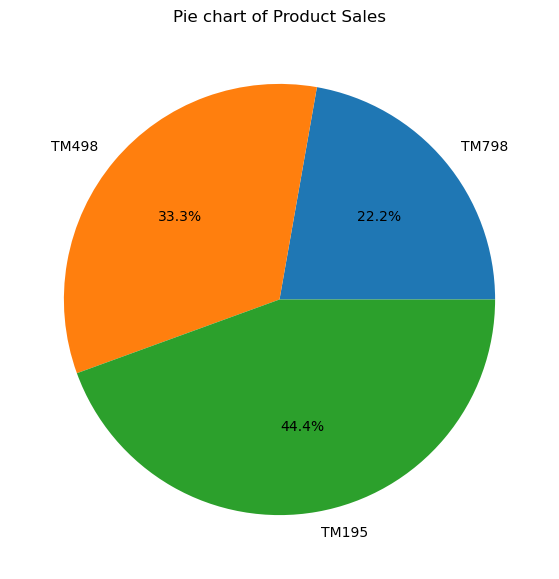

In [8]:
# group data by Product and count the number of rows
grouped = cardio.groupBy("Product").agg(count("*").alias("count"))

# convert to Pandas dataframe for visualization
cardio = grouped.toPandas()

# create a pie chart
fig, ax = plt.subplots(figsize=(14, 7))
ax.pie(cardio['count'], labels=cardio['Product'], autopct='%1.1f%%')
ax.set_title('Pie chart of Product Sales')

# display the chart
plt.show()

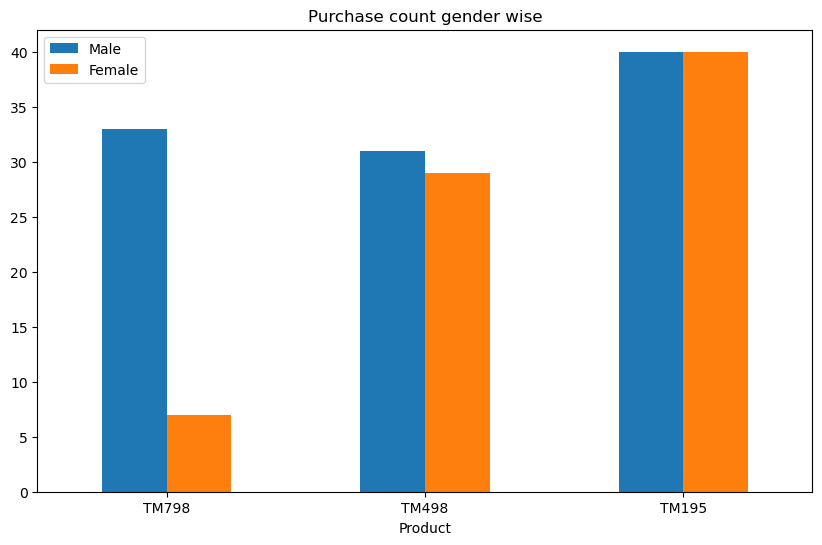

In [9]:
# group by Product and Gender and count the number of rows
grouped = cardio.groupBy("Product").pivot("Gender", ["Male", "Female"]).agg(count("*").alias("count"))

# convert to Pandas dataframe and plot

cardio = grouped.toPandas()
cardio.plot(kind="bar", x="Product", y=["Male", "Female"], figsize=(10, 6))
plt.title("Purchase count gender wise")

# set custom y-tick marks
plt.yticks(range(0, 41, 5))

# Rotate x-axis tick labels
plt.xticks(rotation=0)

plt.show()

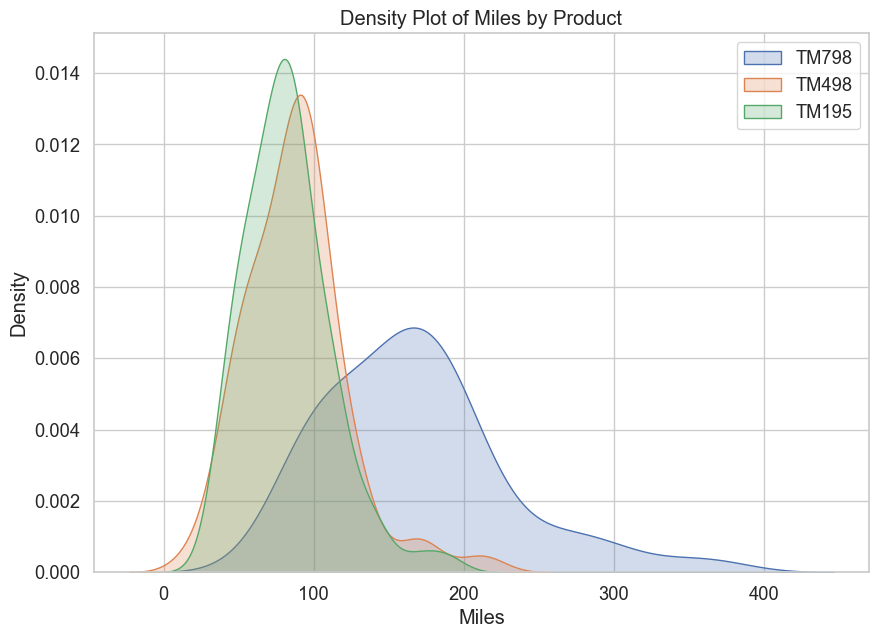

In [16]:
# calculate average miles for each product
avg_miles_cardio = cardio.groupBy('Product').agg(avg('Miles').alias('AvgMiles'))

# create a list of product names
product_names = [row['Product'] for row in avg_miles_cardio.select('Product').collect()]

# create a density plot for each product
sns.set_style('whitegrid')
fig, ax = plt.subplots()
for product_name in product_names:
    miles = cardio.filter(col('Product') == product_name).select('Miles').rdd.flatMap(lambda x: x).collect()
    sns.kdeplot(miles, shade=True, label=product_name, ax=ax)

# set the chart title and axis labels
ax.set_title('Density Plot of Miles by Product')
ax.set_xlabel('Miles')
ax.set_ylabel('Density')

# add a legend and display the plot
ax.legend()
plt.show()

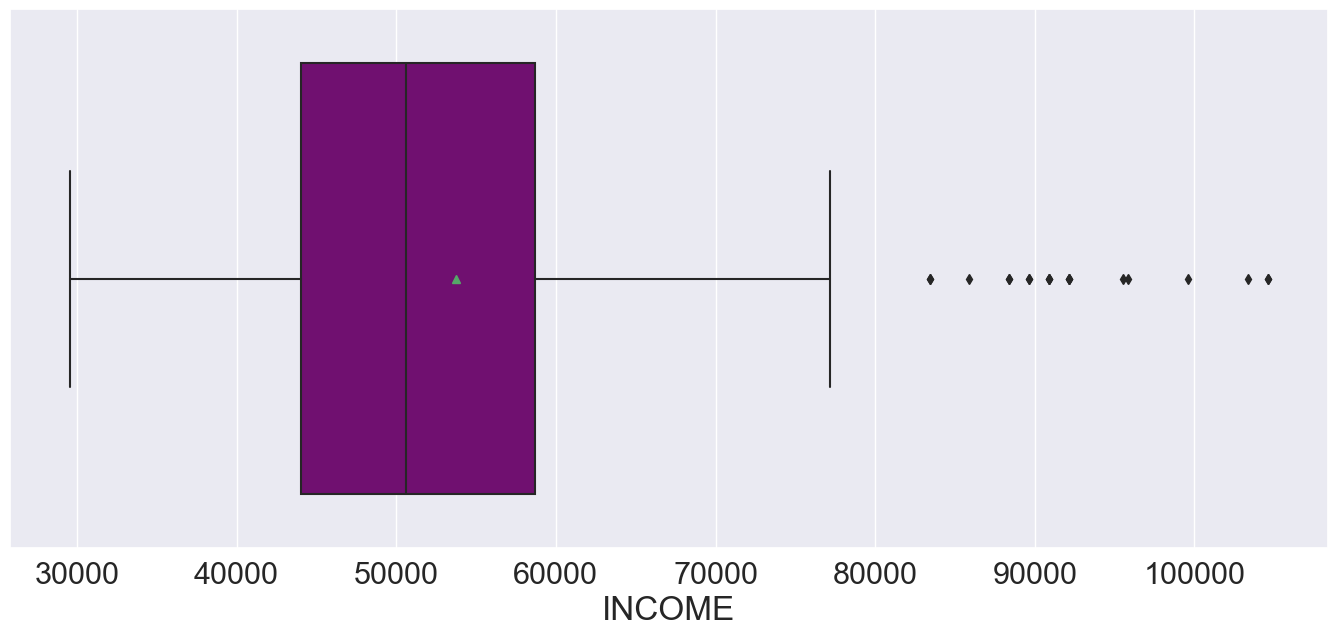

In [11]:
def dist_box_violin(data, col_name):
    Name = col_name.upper()
    fig, ax = plt.subplots(1, figsize=(17, 7))
    sns.boxplot(x=data.select(Name).toPandas()[Name], showmeans=True, orient='h', color="purple")

dist_box_violin(cardio, "Income")

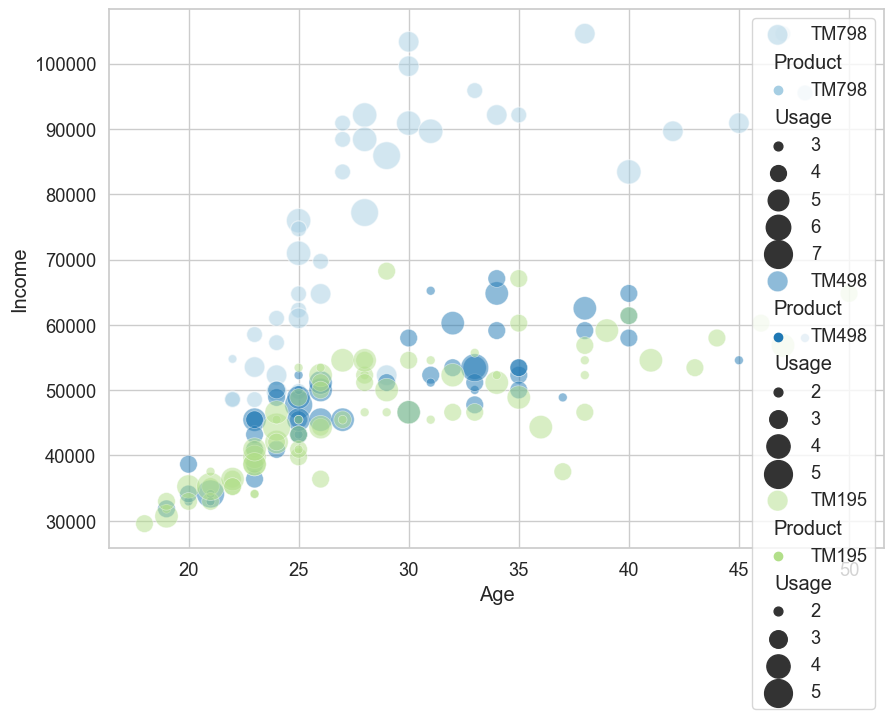

In [35]:
# create a custom palette with different colors for each product
custom_palette = sns.color_palette("Paired", len(cardio.select('Product').distinct().collect()))

# create a new figure
fig, ax = plt.subplots()

# loop over the products and plot each one separately
for i, product in enumerate(cardio.select('Product').distinct().rdd.map(lambda r: r[0]).collect()):
    product_cardio = cardio.filter(cardio['Product'] == product).toPandas()
    product_cardio['Product'] = product  # create a new column with the product name
    sns.scatterplot(x="Age", y="Income", hue="Product", size="Usage", sizes=(40, 400), alpha=.5, palette=[custom_palette[i]],
                    data=product_cardio, ax=ax, label=product)

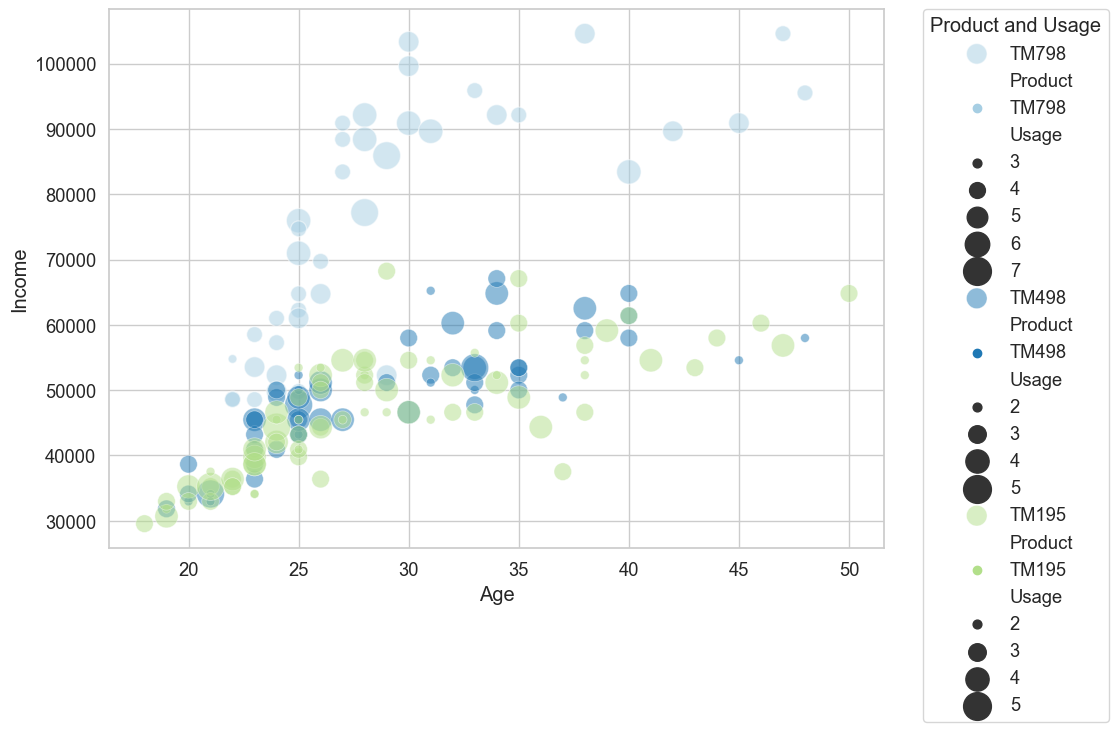

In [37]:
# Testing
# create a custom palette with different colors for each product
custom_palette = sns.color_palette("Paired", len(cardio.select('Product').distinct().collect()))

# create a new figure
fig, ax = plt.subplots()

# loop over the products and plot each one separately
for i, product in enumerate(cardio.select('Product').distinct().rdd.map(lambda r: r[0]).collect()):
    product_cardio = cardio.filter(cardio['Product'] == product).toPandas()
    product_cardio['Product'] = product  # create a new column with the product name
    sns.scatterplot(x="Age", y="Income", hue="Product", size="Usage", sizes=(40, 400), alpha=.5, palette=[custom_palette[i]],
                    data=product_cardio, ax=ax, label=product)

# adjust the size of the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Product and Usage')

In [ ]:
# Convert string columns to numerical indices
product_indexer = StringIndexer(inputCol="Product", outputCol="ProductIndex")
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
marital_indexer = StringIndexer(inputCol="MaritalStatus", outputCol="MaritalIndex")
cardio = product_indexer.fit(cardio).transform(cardio)
cardio = gender_indexer.fit(cardio).transform(cardio)
cardio = marital_indexer.fit(cardio).transform(cardio)

# Drop the unwanted columns
cardio = cardio.drop("ProductIndex", "GenderIndex", "MaritalIndex")

# Create a vector assembler to combine the relevant columns into a single vector column
assembler = VectorAssembler(inputCols=[col for col in cardio.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]],
                            outputCol="features")

# Apply the assembler to our dataframe to create the vector column
cardio_transformed = assembler.transform(cardio)

# Calculate the correlation matrix using Pearson correlation
corr = Correlation.corr(cardio_transformed, "features", "pearson")

# Extract the correlation matrix as a PySpark DataFrame
corr_cardio = corr.collect()[0]["pearson({})".format("features")].values.reshape(-1, len(cardio.columns)-3)

# Convert the correlation matrix to a pandas DataFrame and display it
corr_pd = pd.DataFrame(corr_cardio, columns=[col for col in cardio.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]], index=[col for col in cardio.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]])
display(corr_pd)

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(corr_pd, annot=True, linewidths=.5, fmt= '.1f', center = 0)

# Add a title to the plot
plt.title("Heatmap")

# Display the plot
plt.show()

In [ ]:
assembler = VectorAssembler(inputCols=['Usage', 'Fitness'], outputCol='features')

# transform the DataFrame using the VectorAssembler
df_assembled = assembler.transform(cardio)

# select the 'features' and 'Miles' columns
df_selected = df_assembled.select('features', 'Miles')

# split the data into training and testing sets
(training_data, testing_data) = df_selected.randomSplit([0.7, 0.3], seed=0)

In [ ]:
lr = LinearRegression(featuresCol='features', labelCol='Miles')

# train the model on the training data
lr_model = lr.fit(training_data)

# make predictions on the testing data
predictions = lr_model.transform(testing_data)

# evaluate the model on the testing data
evaluator = RegressionEvaluator(labelCol='Miles', predictionCol='prediction', metricName='r2')
score = evaluator.evaluate(predictions)

print('Output:', score)

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='Miles')

# fit the model to the training data
lr_model = lr.fit(training_data)

# make predictions on the testing data
predictions = lr_model.transform(testing_data)

# select the predicted values
y_pred = predictions.select(col('prediction')).collect()
evaluator = MulticlassClassificationEvaluator(labelCol='Miles', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print('The accuracy is', accuracy)